# Исследование поведения пользователей мобильного приложения. 
Заказчик: стартап, продающий продукты питания. Нужно разобраться, как ведут себя пользователи их мобильного приложения.




## План исследования: 
## 1. [Подготовка данных](#prepare) 
## 2. [Изучить и проверить данные](#explore) 
## 3. [Исследование воронки событий](#funnel)  
## 4. [Изучение результатов эксперимента](#experiment) 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import math as mth
import warnings

# <a id="prepare" style="color:black">1. Подготовка данных</a>
Заменить названия столбцов на удобные;  
Проверить пропуски и типы данных;  
Добавить столбец даты и времени, а также отдельный столбец дат;  

### Описание данных
Каждая запись в логе — это действие пользователя, или событие.  
`EventName` — название события;  
`DeviceIDHash` ** — уникальный идентификатор пользователя;  
`EventTimestamp` — время события;  
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [2]:
logs_data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
logs_data.head(15)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [3]:
logs_data.columns = ['event_name', 'device_id', 'event_timestamp', 'experiment_id']

In [4]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_name         244126 non-null object
device_id          244126 non-null int64
event_timestamp    244126 non-null int64
experiment_id      244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
logs_data.duplicated().sum()

413

In [6]:
logs_data.drop_duplicates(inplace = True)

In [7]:
logs_data.shape

(243713, 4)

Пропусков данных нет, удалили небольшое количество полных дубликатов.

#### Переведем таймстемп в формат даты

In [8]:
logs_data['event_date'] = pd.to_datetime(logs_data['event_timestamp'], unit='s', errors='coerce')
logs_data['event_day'] = logs_data['event_date'].astype('datetime64[D]')

In [9]:
logs_data.head()

,event_name,device_id,event_timestamp,experiment_id,event_date,event_day
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [10]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
event_name         243713 non-null object
device_id          243713 non-null int64
event_timestamp    243713 non-null int64
experiment_id      243713 non-null int64
event_date         243713 non-null datetime64[ns]
event_day          243713 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


В представленном датасете данные без пропусков. Нашли и удалили незначительное количество полных дубликатов. Так же необходимо было изменить формат даты на корректный, добавили колонки с датой и часами.

# <a id="explore" style="color:black">2. Изучить и проверить данные</a>

#### Сколько всего событий в логе? Сколько всего пользователей в логе? Сколько в среднем событий приходится на пользователя?  


In [11]:
logs_data.shape[0]

243713

In [12]:
logs_data['device_id'].nunique()

7551

In [13]:
logs_data.shape[0] / logs_data['device_id'].nunique()

32.27559263673685

В логе всего 243713 события и 7551 пользователя, в среднем на пользовател приходится 32 события.

#### Проверка данных по времени. Найдем период, за который у нас есть данные

In [14]:
logs_data['event_date'].min()

Timestamp('2019-07-25 04:43:36')

In [15]:
logs_data['event_date'].max()

Timestamp('2019-08-07 21:15:17')

У нас есть данные с 25 июля 2019 по 7 августа 2019

In [16]:
dates_distr = logs_data.groupby('event_day', as_index=False).agg({'event_timestamp': 'count'})
dates_distr.columns=['event_day', 'quantity']
dates_distr

,event_day,quantity
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


Судя по этой таблице на период с 1 по 7 августа приходится гораздо больше записей и это число примерно одинаково. Возможно стоит сомневаться в одинаковости и полноте дянных за весь период. Для дальнейшего анализа можно взять только этот период. Посмотрим как это выглядит на графиках

#### Построим гистограмму по дате и времени

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


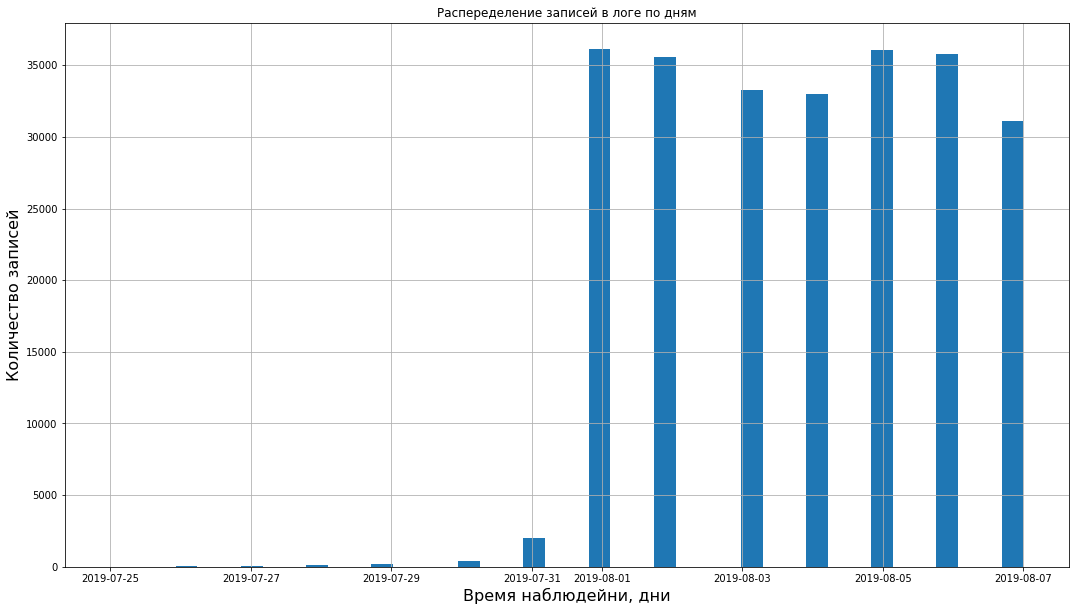

In [17]:
plt.figure(figsize=(18,10))
logs_data['event_day'].hist(bins=42);
plt.title('Распеределение записей в логе по дням')
plt.xlabel('Время наблюдейни, дни', fontsize=16)
plt.ylabel('Количество записей', fontsize=16)
warnings.filterwarnings("ignore")

Я понимаю, что подписи по оси х тут совсем не читаются, пока не придумала вариант лучше, как строить распределение для категориальных данных. Можно, конечно строить график по дням, но тут довольно наглядно видно как различается характер данных. Везде наблюдается суточные колебания активности в ночное и дневное время, но во втором случае распределение имеет довольно четко выраженную синусоиду, в первом более разрозненный. Еще раз это нам скажет о том, что нужно взять данные с 2019-08-01

#### Много ли событий и пользователей потеряли, отбросив старые данные?

In [18]:
logs_data_july = logs_data[logs_data['event_day'] <= pd.to_datetime('2019-07-31')]
logs_data_july.shape[0]

2826

In [19]:
logs_data_august = logs_data[logs_data['event_day'] > pd.to_datetime('2019-07-31')]
logs_data_august.shape[0]

240887

In [20]:
logs_data.shape[0]

243713

In [21]:
((logs_data_july.shape[0]/logs_data.shape[0])*100)

1.159560630741897

Отбросили 1.16% данных по сравнению с изначальной таблицей

#### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп

In [22]:
logs_data_august['experiment_id'].value_counts()

248    84563
246    79302
247    77022
Name: experiment_id, dtype: int64

В выбранных данных есть все три группы.

Изначально мы располагали данными за период с 25 июля по 7 августа 2019 года. После проверки данных на полноту по времени, оставили период с 1 по 7 августа, так что для дальнейшего анализа поведения пользователей у нас есть всего недельные записи. В результате отказа от части даннх потеряли всего 1.16% данных.

# <a id="funnel" style="color:black">3. Исследование воронки событий</a>


In [23]:
logs_data_august.head()

,event_name,device_id,event_timestamp,experiment_id,event_date,event_day
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


#### Cколько всего событий и как часто они встречаются:

In [24]:
all_events = pd.DataFrame(logs_data_august['event_name'].value_counts())
all_events

,event_name
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Самое частое событие -- появление главного экрана, что в полне логично -- это старт работы приложения. Предложение о покупке возникает уже гораздо меньше, видимо, этот экран появляется спустя какое-то продолжительное время или в результате каких-то действий пользователя. К сожалению, неизвестно, какие события предшествуют.  

#### Сколько пользователей совершили каждое из этих событий:

In [25]:
users_ev = (logs_data_august.groupby('event_name')
            .agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending=False))
users_ev

,device_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Судя по таблице в сравнении с предыдущей довольно большое количество событий приходится на одних и тех же пользователей.  
#### Посчитаем долю пользователей, которые хотя бы раз совершали событие:

In [26]:
events_users = all_events.join(users_ev, how='left')
events_users['users_part'] = ((events_users['device_id'] / events_users['event_name'])*100).round(1)
events_users.columns = ['events', 'users', 'users_events %']
events_users

,events,users,users_events %
MainScreenAppear,117328,7419,6.3
OffersScreenAppear,46333,4593,9.9
CartScreenAppear,42303,3734,8.8
PaymentScreenSuccessful,33918,3539,10.4
Tutorial,1005,840,83.6


Получается, что одни и те же пользователи большое количество раз встречаются с одним и тем же событием, кроме обучающего урока, тут 83.6% совершили событие хотя бы раз. 

#### Этапы воронки
Можно предположить, что у воронки следующие этапы: Увидели главный экран -> Увидели экран с предложением о покупке -> Экран с платежными данными -> Успешная оплата. Есть еще обучающая информация, видимо, она не встраивается в эту последовательность.
1.`MainScreenAppear`  
2.`OffersScreenAppear`  
3.`CartScreenAppear`  
4.`PaymentScreenSuccessful`  

#### Посчитаем, какая доля пользователей проходит на следующий шаг воронки

In [27]:
events_users_conversion = events_users.iloc[0:4]

events_users_conversion['conversion_prev_%'] = (((1 + events_users_conversion['users']
                                                  .pct_change())*100).fillna(100).round(1))

usrs = events_users_conversion.columns.get_loc('users')
events_users_conversion['conversion_first_%'] = ((events_users_conversion.iloc[1:, usrs] /
                                                 events_users_conversion.iat[0, usrs]*100).round(1))

events_users_conversion['conversion_first_%'] = events_users_conversion['conversion_first_%'].fillna(100)

In [28]:
events_users_conversion

,events,users,users_events %,conversion_prev_%,conversion_first_%
MainScreenAppear,117328,7419,6.3,100.0,100.0
OffersScreenAppear,46333,4593,9.9,61.9,61.9
CartScreenAppear,42303,3734,8.8,81.3,50.3
PaymentScreenSuccessful,33918,3539,10.4,94.8,47.7


Больше всего теряется пользователей между первым и вторым шагом. До оплаты доходят 47.7% пользователей с первого шага. Больше всего уходит пользователей на шаге между появлением первого экрана и экрана с предложением покупки, интересно, какие шаги или какое время есть между этими двумя шагами.  
Интересна разница между шагом CartScreenAppear и PaymentScreenSuccessful: к шагу PaymentScreenSuccessful доходит 94.8% от предыдущего шага. Возможно, это связано с трудностями с оплатой, или пользовтаель стихийно передумывает

# <a id="experiment" style="color:black">4. Изучение результатов эксперимента</a>

In [29]:
logs_data_august.head()

,event_name,device_id,event_timestamp,experiment_id,event_date,event_day
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


#### Посчитаем количество пользовтелей в каждой группе эксперимента  
`246` и `247` — контрольные группы (группы со старыми шрифтами)  
`248` — экспериментальная (группа с новыми шрифтами)

In [30]:
logs_data_august['experiment_id'].value_counts()

248    84563
246    79302
247    77022
Name: experiment_id, dtype: int64

#### Проверить, находят ли статистические критерии разницу между выборками 246 и 247
Поскольку мы будем сравнивать этапы воронки с первым, оценивая долю пользователей совершивших следующий шаг в группах, уместно будет использовать z-тест. Нужно будет сравнить с помощью z-теста проценты конвертации в каждое из событий в группах.

In [31]:
group_246 = (logs_data_august.query('experiment_id == 246')
             .groupby('event_name', as_index=False).agg({'device_id': 'nunique'}))
group_246.columns = ['event_name', 'users_count']
group_246 = group_246.loc[0:3]
group_246.set_index('event_name', inplace=True)
group_246.sort_values(by='users_count', ascending=False, inplace=True)
group_246

,users_count
event_name,
MainScreenAppear,2450
OffersScreenAppear,1542
CartScreenAppear,1266
PaymentScreenSuccessful,1200


In [32]:
group_247 = (logs_data_august.query('experiment_id == 247')
             .groupby('event_name', as_index=False).agg({'device_id': 'nunique'}))
group_247.columns = ['event_name', 'users_count']
group_247 = group_247.loc[0:3]
group_247.set_index('event_name', inplace=True)
group_247.sort_values(by='users_count', ascending=False, inplace=True)
group_247

,users_count
event_name,
MainScreenAppear,2476
OffersScreenAppear,1520
CartScreenAppear,1238
PaymentScreenSuccessful,1158


#### Нахождение уровня значимости

Мы будем проводить несколько сравнений на одних и тех же данных, скорректируем уровень значимости. Воспользуемся поправкой Шидака. Нам предстоит 3 сравнения в одной группе 246/247, 3 сравнения в двух группах 246/248 247/248 и 3 сравнения в однной группе (246+247)/248.  
Всего 3+3*2+3 12 сравнений.

In [33]:
alpha = (1-(1-0.05))**1/12
alpha

0.00416666666666667

#### Сравнение групп 246 и 247  
Нулевой гипотезой будет: "Между группами нет значимого различия"  
Альтернативная гипотеза: "Между группами есть значимая разница"

In [34]:
def z_comparer(groups, step):
    first_steps = list(map(lambda x: x.loc['MainScreenAppear', 'users_count'], groups))
    next_steps = list(map(lambda x: x.loc[step, 'users_count'], groups))
    p1 = next_steps[0] / first_steps[0]
    p2 = next_steps[1] / first_steps[1]
      
    p_combined = (next_steps[0] + next_steps[1]) / (first_steps[0] + first_steps[1])
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/first_steps[0] + 1/first_steps[1]))
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
     
    print('p-значение: ', p_value, 'для: ', step)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

In [35]:
for step in ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    z_comparer([group_246, group_247], step)

p-значение:  0.2622344959255778 для:  OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
p-значение:  0.24012327015939383 для:  CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
p-значение:  0.12044299485641763 для:  PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Мы хотели проверить значима ли между контрольными группами разница в долях пользователей, переходивших по шагам воронки. Мы проверили, что тестовые группы равны, значит данные собраны корректно.  
Теперь приступим к сравнению группы, где изменились шрифты и двух контрольных груп поочередно:

In [36]:
usrs_246 = group_246.columns.get_loc('users_count')
group_246['conversion %'] = ((group_246.iloc[1:, usrs_246] /
                              group_246.iat[0, usrs_246]*100).round(1))

group_246['conversion %'] = group_246['conversion %'].fillna(100)

In [37]:
usrs_247 = group_247.columns.get_loc('users_count')
group_247['conversion %'] = ((group_247.iloc[1:, usrs_247] /
                              group_247.iat[0, usrs_247]*100).round(1))

group_247['conversion %'] = group_247['conversion %'].fillna(100)

#### Сравнение групп 246 и 248

Сформируем группу с экспериментом 248

In [38]:
group_248 = (logs_data_august.query('experiment_id == 248')
             .groupby('event_name', as_index=False).agg({'device_id': 'nunique'}))
group_248.columns = ['event_name', 'users_count']
group_248 = group_248.loc[0:3]
group_248.set_index('event_name', inplace=True)
group_248.sort_values(by='users_count', ascending=False, inplace=True)
group_248

,users_count
event_name,
MainScreenAppear,2493
OffersScreenAppear,1531
CartScreenAppear,1230
PaymentScreenSuccessful,1181


In [39]:
for step in ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    z_comparer([group_246, group_248], step)

p-значение:  0.2684281587249231 для:  OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
p-значение:  0.1006104270048993 для:  CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
p-значение:  0.2582638437556217 для:  PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


In [40]:
group_248

,users_count
event_name,
MainScreenAppear,2493
OffersScreenAppear,1531
CartScreenAppear,1230
PaymentScreenSuccessful,1181


In [41]:
usrs_248 = group_248.columns.get_loc('users_count')
group_248['conversion %'] = ((group_248.iloc[1:, usrs_248] /
                              group_248.iat[0, usrs_248]*100).round(1))

group_248['conversion %'] = group_248['conversion %'].fillna(100)

group_248

,users_count,conversion %
event_name,,
MainScreenAppear,2493,100.0
OffersScreenAppear,1531,61.4
CartScreenAppear,1230,49.3
PaymentScreenSuccessful,1181,47.4


Между группой с измененными шрифтами и контрольной группой 246 нет статистически значимых различий в процентах конверсий из первого шака в последующие

#### Сравнение групп 247 и 248

In [42]:
for step in ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    z_comparer([group_247, group_248], step)

p-значение:  0.9869365252844515 для:  OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
p-значение:  0.6408180183192491 для:  CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
p-значение:  0.6699208079332859 для:  PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


И здесь такая же история

In [43]:
group_246.join(group_247, how='left', lsuffix='_246', rsuffix='_247').join(group_248, rsuffix='_248')

,users_count_246,conversion %_246,users_count_247,conversion %_247,users_count,conversion %
event_name,,,,,,
MainScreenAppear,2450,100.0,2476,100.0,2493,100.0
OffersScreenAppear,1542,62.9,1520,61.4,1531,61.4
CartScreenAppear,1266,51.7,1238,50.0,1230,49.3
PaymentScreenSuccessful,1200,49.0,1158,46.8,1181,47.4


Если смотреть только на проценты конверсий, выходит, что до экрана с успешной оплатой доходят больше процентов пользователей из группы 246

#### Сравнение групп (247 + 246) и 248

In [44]:
group_246_247 = (logs_data_august[(logs_data_august['experiment_id'] == 246) |
                                               (logs_data_august['experiment_id'] == 247)]
             .groupby('event_name', as_index=False).agg({'device_id': 'nunique'}))
group_246_247.columns = ['event_name', 'users_count']
group_246_247 = group_246_247.loc[0:3]
group_246_247.set_index('event_name', inplace=True)
group_246_247.sort_values(by='users_count', ascending=False, inplace=True)
group_246_247

,users_count
event_name,
MainScreenAppear,4926
OffersScreenAppear,3062
CartScreenAppear,2504
PaymentScreenSuccessful,2358


In [45]:
for step in ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    z_comparer([group_246_247, group_248], step)

p-значение:  0.5308589432077624 для:  OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
p-значение:  0.22404678803657152 для:  CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
p-значение:  0.6863094718086811 для:  PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


В случае сравнения объединенных контрольных групп с группой шрифтов разница тоже незначима статистически. Изменение шрифтов на поведение пользователей не повлияло, так что если дизайнеры хотят его изменить из эстетических убеждений, они спокойно могут это сделать.

# Выводы
* Мы располагаем данными с 25 июля по 7 августа.
* В среднем за этот период на одного пользователя приложения приходится 32 события. Много событий приходится на одних и тех же пользователей. Например, событие первого экрана происходит 117328, но видят его 7418 пользователей. 

In [46]:
events_users

,events,users,users_events %
MainScreenAppear,117328,7419,6.3
OffersScreenAppear,46333,4593,9.9
CartScreenAppear,42303,3734,8.8
PaymentScreenSuccessful,33918,3539,10.4
Tutorial,1005,840,83.6


* Так же происходит и с другими событиями. (Вот к тьюториалу возвращаются меньше всего людей :). Получается, если посчитать именно пользователей, охват у приложения не такой уж большой. Но эти пользователи заходят в приложение много раз смотрят на продукты и ничего не покупают.

In [47]:
events_users_conversion

,events,users,users_events %,conversion_prev_%,conversion_first_%
MainScreenAppear,117328,7419,6.3,100.0,100.0
OffersScreenAppear,46333,4593,9.9,61.9,61.9
CartScreenAppear,42303,3734,8.8,81.3,50.3
PaymentScreenSuccessful,33918,3539,10.4,94.8,47.7


* Больше всего пользователей уходят на этапе между открытием приложения и экраном с предложением о покупке. в этот момент уходит почти 40% пользователей, то есть они даже не успевают увидеть экран с предложением. Тут сложно узнать, что именно отталкивает пользователей, может быть они заходят из праздного интереса, может быть им не нравятся цены.
* Эксперимент с введением новых шрифтов показал, что это не влияет на действия пользователей